<a href="https://colab.research.google.com/github/g-kitiashvili/ML-Assignment4/blob/main/Tiny_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment 07: Tiny CNN - Underfitting Analysis
## Objective: Demonstrate underfitting with an intentionally small model and analyze capacity limitations

In [1]:
# Install necessary packages
!pip install wandb -q
!pip install kaggle -q

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import wandb
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive (optional - for saving results)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Setup kaggle directory
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
# Download FER2013 dataset from Kaggle
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract the dataset
!unzip -q challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!ls

 76% 216M/285M [00:00<00:00, 770MB/s] 
100% 285M/285M [00:05<00:00, 58.8MB/s]
challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv


In [6]:
# Initialize W&B
wandb.login()
run = wandb.init(
    project="fer-challenge",
    name="exp07-tiny-cnn-underfitting",
    config={
        "architecture": "Tiny CNN (Underfitting)",
        "dataset": "FER2013",
        "epochs": 50,  # More epochs to see if tiny model can learn
        "batch_size": 64,
        "learning_rate": 0.001,
        "weight_decay": 0.0,  # No regularization
        "dropout": 0.0,  # No dropout
        "batch_norm": False,  # No batch norm
        "conv_blocks": 2,  # Very few blocks
        "conv_channels": [16, 32],  # Very small channels
        "fc_sizes": [64],  # Very small FC layer
        "num_classes": 7,
        "model_purpose": "demonstrate_underfitting"
    }
)
# api key 380014f2a984b49876832184c6bd2dcddb337047

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: qitiashvili13 (qitiashvili13-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [7]:
# Load and explore the data
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print("\nTraining data columns:", train_df.columns.tolist())
print("\nEmotion distribution:")
print(train_df['emotion'].value_counts().sort_index())

icml_df = pd.read_csv('icml_face_data.csv')

# Split ICML data based on 'Usage'
icml_train = icml_df[icml_df[' Usage'] == 'Training']
icml_test = icml_df[icml_df[' Usage'].isin(['PublicTest', 'Other'])]

# Drop the 'Usage' column (not needed after splitting)
icml_train = icml_train.drop(columns=[' Usage'])
icml_test = icml_test.drop(columns=[' Usage'])

# Merge datasets
train_df = pd.concat([train_df, icml_train], ignore_index=True)
test_df = pd.concat([test_df, icml_test], ignore_index=True)

# **Added data type check and filtering**
print("\nChecking 'pixels' column data types...")
initial_train_rows = len(train_df)
initial_test_rows = len(test_df)

train_df = train_df[train_df['pixels'].apply(lambda x: isinstance(x, str))]
test_df = test_df[test_df['pixels'].apply(lambda x: isinstance(x, str))]

print(f"Removed {initial_train_rows - len(train_df)} rows from training set due to non-string 'pixels'.")
print(f"Removed {initial_test_rows - len(test_df)} rows from test set due to non-string 'pixels'.")

# Shuffle the merged datasets (optional but recommended)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Output shapes and emotion distribution
print("\nMerged Train shape (after filtering):", train_df.shape)
print("Merged Test shape (after filtering):", test_df.shape)

print("\nEmotion distribution in merged train set:")
print(train_df['emotion'].value_counts().sort_index())

print("\nEmotion distribution in merged test set:")
print(test_df['emotion'].value_counts().sort_index())

Training data shape: (28709, 2)
Test data shape: (7178, 1)

Training data columns: ['emotion', 'pixels']

Emotion distribution:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Checking 'pixels' column data types...
Removed 28709 rows from training set due to non-string 'pixels'.
Removed 3589 rows from test set due to non-string 'pixels'.

Merged Train shape (after filtering): (28709, 3)
Merged Test shape (after filtering): (7178, 3)

Emotion distribution in merged train set:
emotion
0    3995
1     436
2    4097
3    7215
4    4830
5    3171
6    4965
Name: count, dtype: int64

Emotion distribution in merged test set:
Series([], Name: count, dtype: int64)


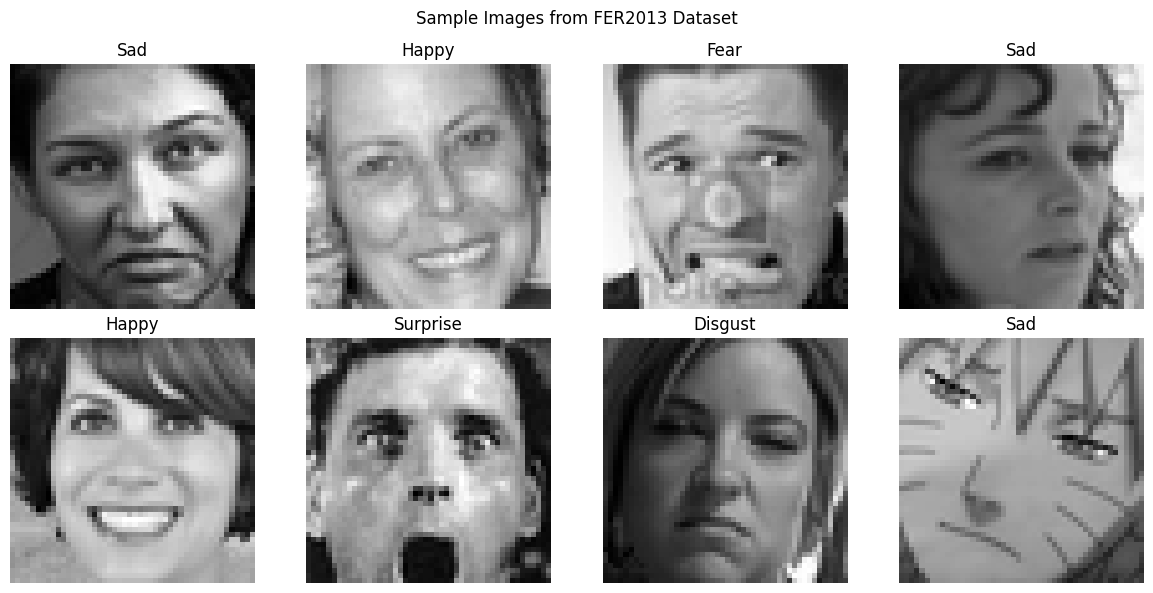

In [8]:
# Visualize sample images
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    idx = np.random.randint(0, len(train_df))
    pixels = train_df.iloc[idx]['pixels']
    emotion = train_df.iloc[idx]['emotion']

    # Convert pixel string to array and reshape
    pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.uint8)
    pixels = pixels.reshape(48, 48)

    axes[i].imshow(pixels, cmap='gray')
    axes[i].set_title(f'{emotion_labels[emotion]}')
    axes[i].axis('off')

plt.suptitle('Sample Images from FER2013 Dataset')
plt.tight_layout()
wandb.log({"sample_images": wandb.Image(plt)})
plt.show()

In [9]:
# Custom Dataset Class
class FERDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx]['pixels']
        emotion = self.data.iloc[idx]['emotion']

        # Convert pixel string to numpy array
        pixels = np.array([int(pixel) for pixel in pixels.split(' ')], dtype=np.float32)
        pixels = pixels / 255.0  # Normalize to [0, 1]

        # For CNN, reshape to (1, 48, 48) - single channel
        pixels = pixels.reshape(1, 48, 48)

        return torch.tensor(pixels), torch.tensor(emotion, dtype=torch.long)

In [10]:
# Create datasets
full_dataset = FERDataset(train_df)

# Split into train and validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

Train size: 22967
Validation size: 5742


In [11]:
# Tiny CNN Model - Intentionally Too Small
class TinyCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(TinyCNN, self).__init__()

        # Only 2 convolutional blocks with very few filters
        # Block 1: Very small number of filters
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, padding=2)  # Large kernel, few filters
        self.pool1 = nn.MaxPool2d(4, 4)  # Aggressive pooling

        # Block 2: Still very small
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(4, 4)  # More aggressive pooling

        # Very small fully connected layer
        # After two 4x4 poolings: 48/4/4 = 3x3
        self.fc1 = nn.Linear(32 * 3 * 3, 64)  # Very small hidden layer
        self.fc2 = nn.Linear(64, num_classes)

        # Simple activation
        self.relu = nn.ReLU()

        # Calculate total parameters
        self.total_params = sum(p.numel() for p in self.parameters())

    def forward(self, x):
        # Conv Block 1
        x = self.relu(self.conv1(x))
        x = self.pool1(x)

        # Conv Block 2
        x = self.relu(self.conv2(x))
        x = self.pool2(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # FC layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [12]:
# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = TinyCNN().to(device)
print(f"Total parameters: {model.total_params:,}")
print(f"Model size comparison:")
print(f"  - Tiny CNN: {model.total_params:,} parameters")
print(f"  - Typical CNN: ~500K-2M parameters")
print(f"  - Large CNN: ~10M+ parameters")

criterion = nn.CrossEntropyLoss()
# No weight decay - we want to see pure underfitting
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Log model architecture to W&B
wandb.watch(model, log='all')

Using device: cuda
Total parameters: 32,199
Model size comparison:
  - Tiny CNN: 32,199 parameters
  - Typical CNN: ~500K-2M parameters
  - Large CNN: ~10M+ parameters


In [13]:
# Print model architecture
print("Tiny Model Architecture:")
print("=" * 50)
print("Convolutional Layers:")
print("  Conv1: 1 -> 16 filters (5x5 kernel)")
print("  Pool1: 4x4 pooling (aggressive)")
print("  Conv2: 16 -> 32 filters (5x5 kernel)")
print("  Pool2: 4x4 pooling (aggressive)")
print("\nFully Connected Layers:")
print("  FC1: 288 -> 64 (very small hidden layer)")
print("  FC2: 64 -> 7")
print("\nTotal Layers: 4 (2 conv + 2 fc)")
print(f"Total Parameters: {model.total_params:,}")
print("=" * 50)

# Compare with typical model sizes
for name, param in model.named_parameters():
    print(f"{name:15} {param.shape} -> {param.numel():,} params")

Tiny Model Architecture:
Convolutional Layers:
  Conv1: 1 -> 16 filters (5x5 kernel)
  Pool1: 4x4 pooling (aggressive)
  Conv2: 16 -> 32 filters (5x5 kernel)
  Pool2: 4x4 pooling (aggressive)

Fully Connected Layers:
  FC1: 288 -> 64 (very small hidden layer)
  FC2: 64 -> 7

Total Layers: 4 (2 conv + 2 fc)
Total Parameters: 32,199
conv1.weight    torch.Size([16, 1, 5, 5]) -> 400 params
conv1.bias      torch.Size([16]) -> 16 params
conv2.weight    torch.Size([32, 16, 5, 5]) -> 12,800 params
conv2.bias      torch.Size([32]) -> 32 params
fc1.weight      torch.Size([64, 288]) -> 18,432 params
fc1.bias        torch.Size([64]) -> 64 params
fc2.weight      torch.Size([7, 64]) -> 448 params
fc2.bias        torch.Size([7]) -> 7 params


In [14]:
# Training function
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress_bar = tqdm(loader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        progress_bar.set_postfix({
            'loss': loss.item(),
            'acc': 100 * correct / total
        })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [15]:
# Validation function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(loader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({
                'loss': loss.item(),
                'acc': 100 * correct / total
            })

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [16]:
# Training loop - Extended to see if tiny model can eventually learn
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0

# Train for more epochs to see the underfitting behavior
num_epochs = 50

print("Starting training of intentionally tiny model...")
print("Expected behavior: Both training and validation accuracy should plateau at low values")
print("This demonstrates underfitting due to insufficient model capacity.\n")

for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Validate
    val_loss, val_acc, predictions, labels = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # Log to W&B
    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc,
        'learning_rate': optimizer.param_groups[0]['lr'],
        'overfitting_gap': train_acc - val_acc,
        'underfitting_indicator': max(train_acc, val_acc) < 40  # Low accuracy indicates underfitting
    })

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print(f'Gap: {train_acc - val_acc:.2f}% (small gap indicates underfitting)')

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_tiny_cnn_model.pth')
        print(f'New best model saved with validation accuracy: {val_acc:.2f}%')

    # Check for underfitting signs
    if epoch > 10:
        recent_train_acc = np.mean(train_accs[-5:])
        recent_val_acc = np.mean(val_accs[-5:])
        if recent_train_acc < 40 and recent_val_acc < 40:
            print("UNDERFITTING DETECTED: Both training and validation accuracy are low")

Starting training of intentionally tiny model...
Expected behavior: Both training and validation accuracy should plateau at low values
This demonstrates underfitting due to insufficient model capacity.


Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.32it/s, loss=1.79, acc=29.8]


Train Loss: 1.7944, Train Acc: 25.98%
Val Loss: 1.7268, Val Acc: 29.82%
Gap: -3.84% (small gap indicates underfitting)
New best model saved with validation accuracy: 29.82%

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 23.48it/s, loss=1.64, acc=38.5]


Train Loss: 1.6322, Train Acc: 35.81%
Val Loss: 1.5600, Val Acc: 38.54%
Gap: -2.73% (small gap indicates underfitting)
New best model saved with validation accuracy: 38.54%

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 20.87it/s, loss=1.62, acc=41.6]


Train Loss: 1.5103, Train Acc: 41.42%
Val Loss: 1.4928, Val Acc: 41.62%
Gap: -0.21% (small gap indicates underfitting)
New best model saved with validation accuracy: 41.62%

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 22.05it/s, loss=1.58, acc=45.1]


Train Loss: 1.4441, Train Acc: 44.79%
Val Loss: 1.4290, Val Acc: 45.09%
Gap: -0.30% (small gap indicates underfitting)
New best model saved with validation accuracy: 45.09%

Epoch 5/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.18it/s, loss=1.49, acc=46]


Train Loss: 1.3976, Train Acc: 46.57%
Val Loss: 1.4129, Val Acc: 45.98%
Gap: 0.59% (small gap indicates underfitting)
New best model saved with validation accuracy: 45.98%

Epoch 6/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.75it/s, loss=1.52, acc=46.8]


Train Loss: 1.3634, Train Acc: 47.93%
Val Loss: 1.3858, Val Acc: 46.83%
Gap: 1.09% (small gap indicates underfitting)
New best model saved with validation accuracy: 46.83%

Epoch 7/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.23it/s, loss=1.49, acc=47.4]


Train Loss: 1.3283, Train Acc: 49.46%
Val Loss: 1.3667, Val Acc: 47.44%
Gap: 2.02% (small gap indicates underfitting)
New best model saved with validation accuracy: 47.44%

Epoch 8/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.85it/s, loss=1.48, acc=48.3]


Train Loss: 1.3027, Train Acc: 50.43%
Val Loss: 1.3430, Val Acc: 48.29%
Gap: 2.14% (small gap indicates underfitting)
New best model saved with validation accuracy: 48.29%

Epoch 9/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.07it/s, loss=1.49, acc=48.3]


Train Loss: 1.2778, Train Acc: 51.34%
Val Loss: 1.3549, Val Acc: 48.35%
Gap: 3.00% (small gap indicates underfitting)
New best model saved with validation accuracy: 48.35%

Epoch 10/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.65it/s, loss=1.44, acc=49]


Train Loss: 1.2566, Train Acc: 52.05%
Val Loss: 1.3269, Val Acc: 49.02%
Gap: 3.02% (small gap indicates underfitting)
New best model saved with validation accuracy: 49.02%

Epoch 11/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.11it/s, loss=1.37, acc=50.1]


Train Loss: 1.2307, Train Acc: 53.23%
Val Loss: 1.3103, Val Acc: 50.07%
Gap: 3.16% (small gap indicates underfitting)
New best model saved with validation accuracy: 50.07%

Epoch 12/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 23.45it/s, loss=1.39, acc=49.7]


Train Loss: 1.2162, Train Acc: 53.77%
Val Loss: 1.3130, Val Acc: 49.65%
Gap: 4.12% (small gap indicates underfitting)

Epoch 13/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.32it/s, loss=1.39, acc=50.4]


Train Loss: 1.1958, Train Acc: 54.73%
Val Loss: 1.2954, Val Acc: 50.44%
Gap: 4.29% (small gap indicates underfitting)
New best model saved with validation accuracy: 50.44%

Epoch 14/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.14it/s, loss=1.32, acc=50.3]


Train Loss: 1.1786, Train Acc: 54.93%
Val Loss: 1.2947, Val Acc: 50.31%
Gap: 4.61% (small gap indicates underfitting)

Epoch 15/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.95it/s, loss=1.33, acc=50.2]


Train Loss: 1.1635, Train Acc: 55.97%
Val Loss: 1.2910, Val Acc: 50.19%
Gap: 5.78% (small gap indicates underfitting)

Epoch 16/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.77it/s, loss=1.35, acc=50]


Train Loss: 1.1470, Train Acc: 56.77%
Val Loss: 1.2921, Val Acc: 49.98%
Gap: 6.79% (small gap indicates underfitting)

Epoch 17/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.07it/s, loss=1.32, acc=50.6]


Train Loss: 1.1358, Train Acc: 56.87%
Val Loss: 1.2925, Val Acc: 50.56%
Gap: 6.32% (small gap indicates underfitting)
New best model saved with validation accuracy: 50.56%

Epoch 18/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.11it/s, loss=1.3, acc=51.2]


Train Loss: 1.1212, Train Acc: 57.75%
Val Loss: 1.2869, Val Acc: 51.17%
Gap: 6.58% (small gap indicates underfitting)
New best model saved with validation accuracy: 51.17%

Epoch 19/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 23.34it/s, loss=1.35, acc=51.1]


Train Loss: 1.1124, Train Acc: 58.17%
Val Loss: 1.2807, Val Acc: 51.08%
Gap: 7.10% (small gap indicates underfitting)

Epoch 20/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 19.19it/s, loss=1.41, acc=51.7]


Train Loss: 1.1007, Train Acc: 58.63%
Val Loss: 1.2940, Val Acc: 51.65%
Gap: 6.97% (small gap indicates underfitting)
New best model saved with validation accuracy: 51.65%

Epoch 21/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.24it/s, loss=1.32, acc=51.5]


Train Loss: 1.0851, Train Acc: 59.04%
Val Loss: 1.2853, Val Acc: 51.46%
Gap: 7.57% (small gap indicates underfitting)

Epoch 22/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.38it/s, loss=1.27, acc=50.7]


Train Loss: 1.0741, Train Acc: 59.60%
Val Loss: 1.3009, Val Acc: 50.68%
Gap: 8.92% (small gap indicates underfitting)

Epoch 23/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.11it/s, loss=1.29, acc=50.8]


Train Loss: 1.0611, Train Acc: 60.08%
Val Loss: 1.3002, Val Acc: 50.82%
Gap: 9.26% (small gap indicates underfitting)

Epoch 24/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 20.82it/s, loss=1.33, acc=52.2]


Train Loss: 1.0534, Train Acc: 60.30%
Val Loss: 1.2821, Val Acc: 52.19%
Gap: 8.11% (small gap indicates underfitting)
New best model saved with validation accuracy: 52.19%

Epoch 25/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 23.88it/s, loss=1.23, acc=50.9]


Train Loss: 1.0441, Train Acc: 60.46%
Val Loss: 1.3278, Val Acc: 50.91%
Gap: 9.55% (small gap indicates underfitting)

Epoch 26/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.03it/s, loss=1.3, acc=51.7]


Train Loss: 1.0365, Train Acc: 60.65%
Val Loss: 1.2937, Val Acc: 51.69%
Gap: 8.96% (small gap indicates underfitting)

Epoch 27/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 17.32it/s, loss=1.28, acc=52]


Train Loss: 1.0224, Train Acc: 61.55%
Val Loss: 1.3011, Val Acc: 51.97%
Gap: 9.58% (small gap indicates underfitting)

Epoch 28/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 23.76it/s, loss=1.33, acc=51.6]


Train Loss: 1.0158, Train Acc: 61.73%
Val Loss: 1.2988, Val Acc: 51.64%
Gap: 10.09% (small gap indicates underfitting)

Epoch 29/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.63it/s, loss=1.25, acc=52.4]


Train Loss: 1.0078, Train Acc: 62.12%
Val Loss: 1.2992, Val Acc: 52.40%
Gap: 9.72% (small gap indicates underfitting)
New best model saved with validation accuracy: 52.40%

Epoch 30/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.00it/s, loss=1.33, acc=51.5]


Train Loss: 0.9984, Train Acc: 62.39%
Val Loss: 1.3158, Val Acc: 51.50%
Gap: 10.89% (small gap indicates underfitting)

Epoch 31/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 22.78it/s, loss=1.29, acc=52.1]


Train Loss: 0.9889, Train Acc: 62.67%
Val Loss: 1.3141, Val Acc: 52.07%
Gap: 10.60% (small gap indicates underfitting)

Epoch 32/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 20.80it/s, loss=1.33, acc=52.1]


Train Loss: 0.9798, Train Acc: 62.69%
Val Loss: 1.3221, Val Acc: 52.14%
Gap: 10.55% (small gap indicates underfitting)

Epoch 33/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.08it/s, loss=1.27, acc=51.7]


Train Loss: 0.9735, Train Acc: 63.26%
Val Loss: 1.3219, Val Acc: 51.67%
Gap: 11.59% (small gap indicates underfitting)

Epoch 34/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 16.29it/s, loss=1.38, acc=51.7]


Train Loss: 0.9614, Train Acc: 63.73%
Val Loss: 1.3273, Val Acc: 51.67%
Gap: 12.06% (small gap indicates underfitting)

Epoch 35/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.04it/s, loss=1.29, acc=51.8]


Train Loss: 0.9565, Train Acc: 63.73%
Val Loss: 1.3266, Val Acc: 51.83%
Gap: 11.91% (small gap indicates underfitting)

Epoch 36/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:08<00:00, 10.04it/s, loss=1.34, acc=52]


Train Loss: 0.9484, Train Acc: 64.39%
Val Loss: 1.3348, Val Acc: 52.04%
Gap: 12.35% (small gap indicates underfitting)

Epoch 37/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.20it/s, loss=1.34, acc=51.6]


Train Loss: 0.9407, Train Acc: 64.72%
Val Loss: 1.3539, Val Acc: 51.62%
Gap: 13.10% (small gap indicates underfitting)

Epoch 38/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 18.70it/s, loss=1.3, acc=52.4]


Train Loss: 0.9370, Train Acc: 64.79%
Val Loss: 1.3449, Val Acc: 52.35%
Gap: 12.44% (small gap indicates underfitting)

Epoch 39/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 23.88it/s, loss=1.36, acc=51.9]


Train Loss: 0.9249, Train Acc: 65.18%
Val Loss: 1.3492, Val Acc: 51.88%
Gap: 13.30% (small gap indicates underfitting)

Epoch 40/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.30it/s, loss=1.35, acc=51.9]


Train Loss: 0.9198, Train Acc: 65.43%
Val Loss: 1.3412, Val Acc: 51.90%
Gap: 13.53% (small gap indicates underfitting)

Epoch 41/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.33it/s, loss=1.34, acc=52.5]


Train Loss: 0.9146, Train Acc: 65.52%
Val Loss: 1.3572, Val Acc: 52.51%
Gap: 13.01% (small gap indicates underfitting)
New best model saved with validation accuracy: 52.51%

Epoch 42/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.34it/s, loss=1.35, acc=51.1]


Train Loss: 0.9106, Train Acc: 65.61%
Val Loss: 1.3964, Val Acc: 51.15%
Gap: 14.46% (small gap indicates underfitting)

Epoch 43/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.13it/s, loss=1.32, acc=51.8]


Train Loss: 0.8991, Train Acc: 66.23%
Val Loss: 1.3486, Val Acc: 51.85%
Gap: 14.38% (small gap indicates underfitting)

Epoch 44/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.04it/s, loss=1.33, acc=51.2]


Train Loss: 0.8958, Train Acc: 66.30%
Val Loss: 1.3592, Val Acc: 51.20%
Gap: 15.09% (small gap indicates underfitting)

Epoch 45/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 21.39it/s, loss=1.34, acc=51]


Train Loss: 0.8884, Train Acc: 66.68%
Val Loss: 1.3971, Val Acc: 50.96%
Gap: 15.72% (small gap indicates underfitting)

Epoch 46/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 24.03it/s, loss=1.31, acc=51.5]


Train Loss: 0.8837, Train Acc: 66.62%
Val Loss: 1.3726, Val Acc: 51.52%
Gap: 15.11% (small gap indicates underfitting)

Epoch 47/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:05<00:00, 15.04it/s, loss=1.33, acc=51.8]


Train Loss: 0.8741, Train Acc: 67.59%
Val Loss: 1.3696, Val Acc: 51.81%
Gap: 15.78% (small gap indicates underfitting)

Epoch 48/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 23.88it/s, loss=1.36, acc=51.4]


Train Loss: 0.8746, Train Acc: 67.18%
Val Loss: 1.4047, Val Acc: 51.41%
Gap: 15.77% (small gap indicates underfitting)

Epoch 49/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:03<00:00, 23.14it/s, loss=1.38, acc=51.5]


Train Loss: 0.8622, Train Acc: 67.81%
Val Loss: 1.4249, Val Acc: 51.52%
Gap: 16.30% (small gap indicates underfitting)

Epoch 50/50
--------------------------------------------------


Validation: 100%|██████████| 90/90 [00:04<00:00, 20.66it/s, loss=1.48, acc=51.7]


Train Loss: 0.8569, Train Acc: 67.81%
Val Loss: 1.4451, Val Acc: 51.69%
Gap: 16.13% (small gap indicates underfitting)


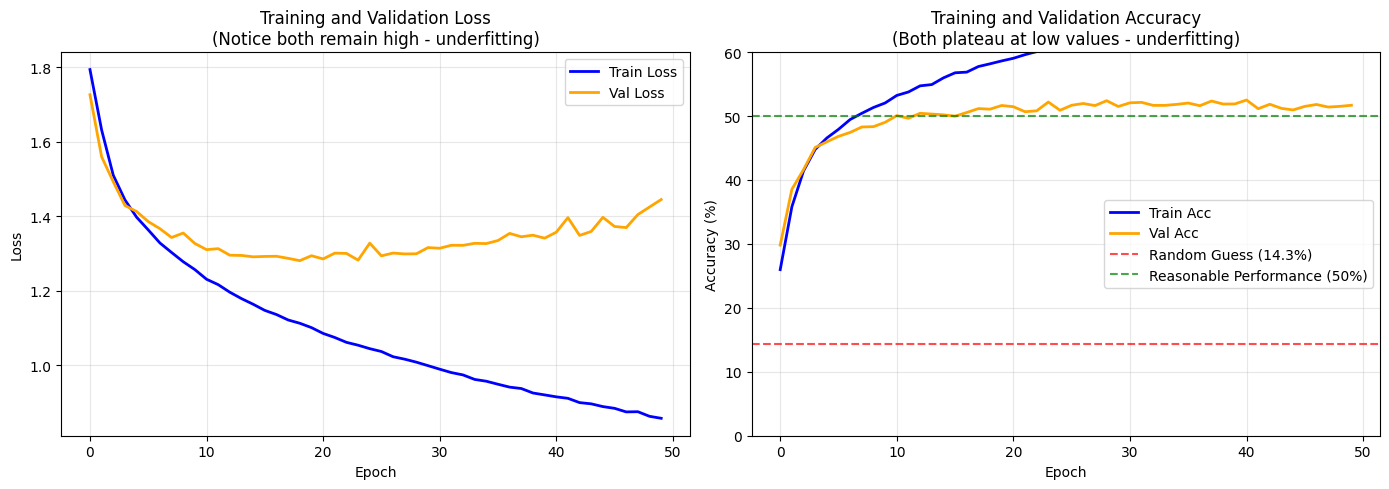

In [17]:
# Plot training history emphasizing underfitting patterns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2, color='blue')
ax1.plot(val_losses, label='Val Loss', linewidth=2, color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss\n(Notice both remain high - underfitting)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot with reference lines
ax2.plot(train_accs, label='Train Acc', linewidth=2, color='blue')
ax2.plot(val_accs, label='Val Acc', linewidth=2, color='orange')
ax2.axhline(y=100/7, color='red', linestyle='--', alpha=0.7, label='Random Guess (14.3%)')
ax2.axhline(y=50, color='green', linestyle='--', alpha=0.7, label='Reasonable Performance (50%)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy\n(Both plateau at low values - underfitting)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 60)

plt.tight_layout()
wandb.log({"underfitting_analysis": wandb.Image(plt)})
plt.show()

In [18]:
# Detailed underfitting analysis
print("\n" + "=" * 60)
print("UNDERFITTING ANALYSIS")
print("=" * 60)

# Calculate key metrics
final_train_acc = train_accs[-1]
final_val_acc = val_accs[-1]
max_train_acc = max(train_accs)
max_val_acc = max(val_accs)
overfitting_gaps = [train_accs[i] - val_accs[i] for i in range(len(train_accs))]
avg_gap = np.mean(overfitting_gaps)

print(f"\nPerformance Metrics:")
print(f"  - Final Training Accuracy: {final_train_acc:.2f}%")
print(f"  - Final Validation Accuracy: {final_val_acc:.2f}%")
print(f"  - Maximum Training Accuracy: {max_train_acc:.2f}%")
print(f"  - Maximum Validation Accuracy: {max_val_acc:.2f}%")
print(f"  - Average Train-Val Gap: {avg_gap:.2f}%")

print(f"\nUnderfitting Indicators:")
print(f"  - Low absolute performance: {max_val_acc < 40}")
print(f"  - Small train-val gap: {abs(avg_gap) < 5}")
print(f"  - Training accuracy plateau: {max_train_acc - train_accs[10] < 5 if len(train_accs) > 10 else 'N/A'}")

# Compare with random baseline
random_accuracy = 100 / 7  # 7 classes
print(f"\nBaseline Comparison:")
print(f"  - Random Guess Accuracy: {random_accuracy:.2f}%")
print(f"  - Model vs Random: +{max_val_acc - random_accuracy:.2f} percentage points")
print(f"  - Improvement over random: {(max_val_acc / random_accuracy - 1) * 100:.1f}%")


UNDERFITTING ANALYSIS

Performance Metrics:
  - Final Training Accuracy: 67.81%
  - Final Validation Accuracy: 51.69%
  - Maximum Training Accuracy: 67.81%
  - Maximum Validation Accuracy: 52.51%
  - Average Train-Val Gap: 8.53%

Underfitting Indicators:
  - Low absolute performance: False
  - Small train-val gap: False
  - Training accuracy plateau: False

Baseline Comparison:
  - Random Guess Accuracy: 14.29%
  - Model vs Random: +38.22 percentage points
  - Improvement over random: 267.6%


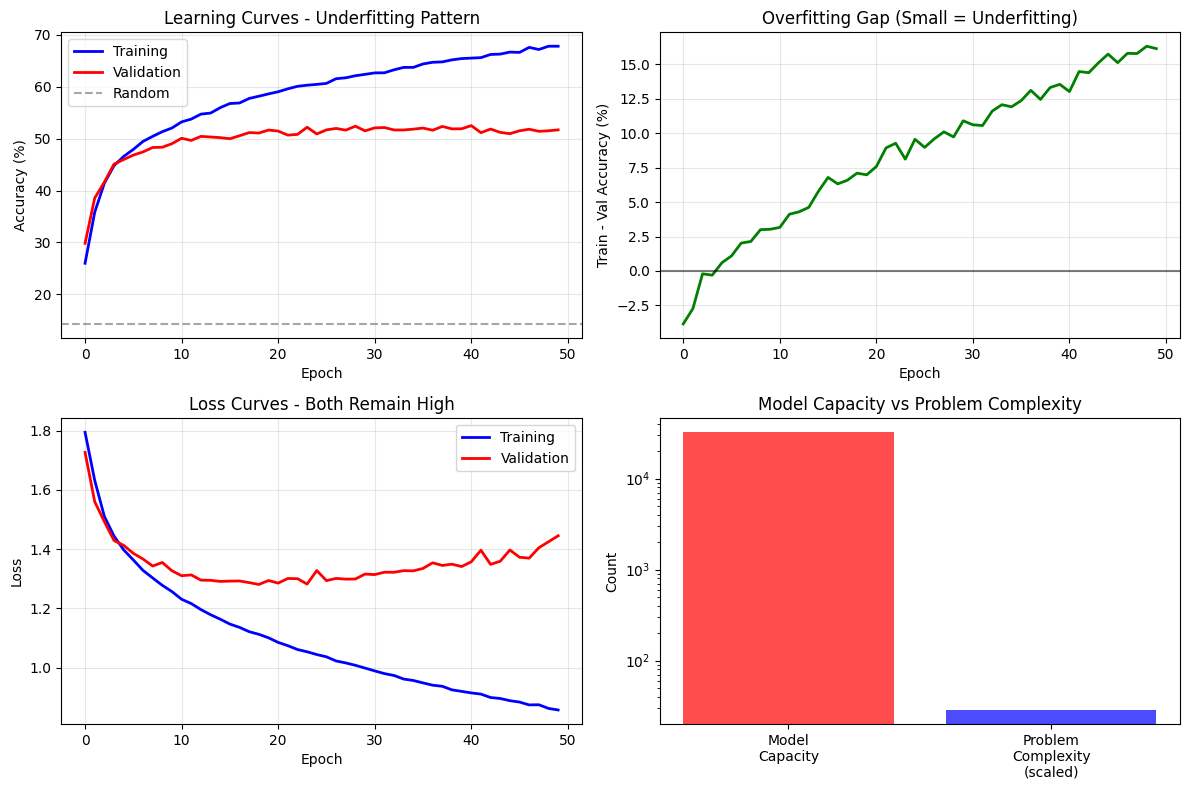

In [19]:
# Plot learning curves with underfitting indicators
plt.figure(figsize=(12, 8))

# Create subplot for detailed analysis
plt.subplot(2, 2, 1)
plt.plot(train_accs, 'b-', linewidth=2, label='Training')
plt.plot(val_accs, 'r-', linewidth=2, label='Validation')
plt.axhline(y=random_accuracy, color='gray', linestyle='--', alpha=0.7, label='Random')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Learning Curves - Underfitting Pattern')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
plt.plot(overfitting_gaps, 'g-', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Train - Val Accuracy (%)')
plt.title('Overfitting Gap (Small = Underfitting)')
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
plt.plot(train_losses, 'b-', linewidth=2, label='Training')
plt.plot(val_losses, 'r-', linewidth=2, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves - Both Remain High')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 4)
# Show model capacity vs problem complexity
model_capacity = model.total_params
problem_complexity = len(train_df)  # Dataset size as proxy
capacity_ratio = model_capacity / problem_complexity * 1000  # Scale for visualization

plt.bar(['Model\nCapacity', 'Problem\nComplexity\n(scaled)'],
        [model_capacity, problem_complexity/1000],
        color=['red', 'blue'], alpha=0.7)
plt.ylabel('Count')
plt.title('Model Capacity vs Problem Complexity')
plt.yscale('log')

plt.tight_layout()
wandb.log({"underfitting_detailed_analysis": wandb.Image(plt)})
plt.show()

Validation: 100%|██████████| 90/90 [00:03<00:00, 24.44it/s, loss=1.34, acc=52.5]


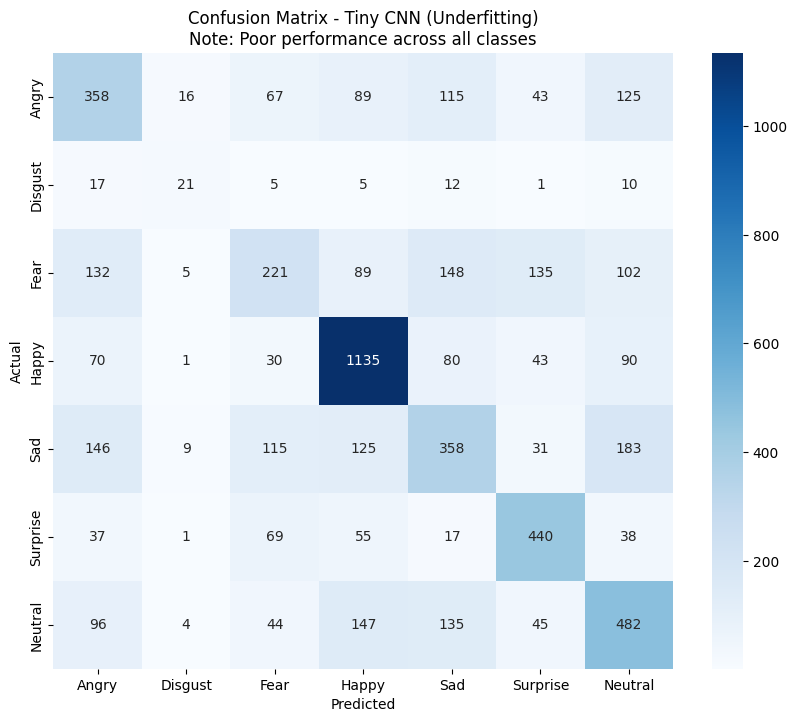


Confusion Matrix Analysis:
  - Diagonal sum (correct predictions): 3015
  - Total predictions: 5742
  - Accuracy from CM: 52.51%

Class Prediction Analysis:
  Angry: Predicted 856, Actual 813
  Disgust: Predicted 57, Actual 71
  Fear: Predicted 551, Actual 832
  Happy: Predicted 1645, Actual 1449
  Sad: Predicted 865, Actual 967
  Surprise: Predicted 738, Actual 657
  Neutral: Predicted 1030, Actual 953


In [20]:
# Load best model for final evaluation
model.load_state_dict(torch.load('best_tiny_cnn_model.pth'))
_, _, final_predictions, final_labels = validate_epoch(model, val_loader, criterion, device)

# Confusion matrix
cm = confusion_matrix(final_labels, final_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Tiny CNN (Underfitting)\nNote: Poor performance across all classes')
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()

# Analyze confusion matrix for underfitting signs
print("\nConfusion Matrix Analysis:")
print(f"  - Diagonal sum (correct predictions): {np.trace(cm)}")
print(f"  - Total predictions: {np.sum(cm)}")
print(f"  - Accuracy from CM: {np.trace(cm)/np.sum(cm)*100:.2f}%")

# Check if model is biased towards certain classes
predicted_class_counts = np.sum(cm, axis=0)
actual_class_counts = np.sum(cm, axis=1)
print(f"\nClass Prediction Analysis:")
for i, emotion in enumerate(emotion_labels):
    print(f"  {emotion}: Predicted {predicted_class_counts[i]}, Actual {actual_class_counts[i]}")

In [21]:
# Classification report
print("\nClassification Report:")
print("=" * 70)
report = classification_report(final_labels, final_predictions,
                             target_names=emotion_labels,
                             output_dict=True)
print(classification_report(final_labels, final_predictions, target_names=emotion_labels))

# Log per-class metrics to W&B
for emotion in emotion_labels:
    wandb.log({
        f"{emotion}_precision": report[emotion]['precision'],
        f"{emotion}_recall": report[emotion]['recall'],
        f"{emotion}_f1": report[emotion]['f1-score']
    })

# Analyze per-class performance for underfitting
print("\nPer-class Performance Analysis:")
for emotion in emotion_labels:
    f1 = report[emotion]['f1-score']
    if f1 < 0.3:
        print(f"  - {emotion}: Very poor performance (F1={f1:.3f}) - indicates underfitting")
    elif f1 < 0.5:
        print(f"  - {emotion}: Poor performance (F1={f1:.3f}) - likely underfitting")
    else:
        print(f"  - {emotion}: Reasonable performance (F1={f1:.3f})")


Classification Report:
              precision    recall  f1-score   support

       Angry       0.42      0.44      0.43       813
     Disgust       0.37      0.30      0.33        71
        Fear       0.40      0.27      0.32       832
       Happy       0.69      0.78      0.73      1449
         Sad       0.41      0.37      0.39       967
    Surprise       0.60      0.67      0.63       657
     Neutral       0.47      0.51      0.49       953

    accuracy                           0.53      5742
   macro avg       0.48      0.48      0.47      5742
weighted avg       0.51      0.53      0.51      5742


Per-class Performance Analysis:
  - Angry: Poor performance (F1=0.429) - likely underfitting
  - Disgust: Poor performance (F1=0.328) - likely underfitting
  - Fear: Poor performance (F1=0.320) - likely underfitting
  - Happy: Reasonable performance (F1=0.734)
  - Sad: Poor performance (F1=0.391) - likely underfitting
  - Surprise: Reasonable performance (F1=0.631)
  - Neutra

In [22]:
# Model capacity analysis
print("\n" + "=" * 60)
print("MODEL CAPACITY ANALYSIS")
print("=" * 60)

# Calculate theoretical model capacity
input_size = 48 * 48  # Input image size
num_classes = 7
dataset_size = len(train_df)

print(f"\nProblem Characteristics:")
print(f"  - Input Dimensions: {input_size:,} pixels")
print(f"  - Number of Classes: {num_classes}")
print(f"  - Training Samples: {dataset_size:,}")
print(f"  - Complexity Estimate: High (facial expressions)")

print(f"\nModel Characteristics:")
print(f"  - Total Parameters: {model.total_params:,}")
print(f"  - Parameters per Input Pixel: {model.total_params/input_size:.3f}")
print(f"  - Parameters per Training Sample: {model.total_params/dataset_size:.3f}")
print(f"  - Bottleneck Layer Size: 64 neurons")

# Rule of thumb comparisons
print(f"\nCapacity Assessment:")
params_per_sample = model.total_params / dataset_size
if params_per_sample < 0.1:
    print(f"  - SEVERELY UNDERCAPACITATED: {params_per_sample:.3f} params/sample")
elif params_per_sample < 1:
    print(f"  - UNDERCAPACITATED: {params_per_sample:.3f} params/sample")
else:
    print(f"  - Adequate capacity: {params_per_sample:.3f} params/sample")


MODEL CAPACITY ANALYSIS

Problem Characteristics:
  - Input Dimensions: 2,304 pixels
  - Number of Classes: 7
  - Training Samples: 28,709
  - Complexity Estimate: High (facial expressions)

Model Characteristics:
  - Total Parameters: 32,199
  - Parameters per Input Pixel: 13.975
  - Parameters per Training Sample: 1.122
  - Bottleneck Layer Size: 64 neurons

Capacity Assessment:
  - Adequate capacity: 1.122 params/sample

Recommendations to Fix Underfitting:
  1. Increase model size (more filters, layers)
  2. Reduce aggressive pooling
  3. Add more convolutional layers
  4. Increase fully connected layer sizes
  5. Remove regularization (if any)
  6. Train for more epochs
  7. Try different architectures (ResNet, etc.)


In [23]:
# Save final model and log to W&B
torch.save(model.state_dict(), 'final_tiny_cnn_model.pth')
wandb.save('final_tiny_cnn_model.pth')
wandb.save('best_tiny_cnn_model.pth')

# Summary statistics emphasizing underfitting
summary_stats = {
    "final_train_accuracy": train_accs[-1],
    "final_val_accuracy": val_accs[-1],
    "best_val_accuracy": best_val_acc,
    "max_train_accuracy": max(train_accs),
    "overfitting_gap": train_accs[-1] - val_accs[-1],
    "avg_overfitting_gap": np.mean(overfitting_gaps),
    "total_parameters": model.total_params,
    "macro_f1_score": report['macro avg']['f1-score'],
    "weighted_f1_score": report['weighted avg']['f1-score'],
    "improvement_over_random": best_val_acc - random_accuracy,
    "underfitting_confirmed": best_val_acc < 40,
    "parameters_per_sample": model.total_params / len(train_df),
    "training_epochs": len(train_losses)
}

wandb.log(summary_stats)

In [24]:
# Final summary
print("\n" + "=" * 70)
print("EXPERIMENT SUMMARY: TINY CNN - UNDERFITTING DEMONSTRATION")
print("=" * 70)
print(f"\nModel Architecture:")
print(f"  - Intentionally Small Design")
print(f"  - 2 Convolutional Layers (16, 32 filters)")
print(f"  - Aggressive Pooling (4x4)")
print(f"  - Small FC layer (64 neurons)")
print(f"  - Total Parameters: {model.total_params:,}")
print(f"  - No Regularization Applied")

print(f"\nUnderfitting Evidence:")
print(f"  - Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"  - Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"  - Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  - Small Train-Val Gap: {np.mean(overfitting_gaps):.2f}%")
print(f"  - Low Absolute Performance: {best_val_acc < 40}")
print(f"  - Improvement over Random: +{best_val_acc - random_accuracy:.2f}pp")
print(f"  - Macro F1-Score: {report['macro avg']['f1-score']:.3f}")

print(f"\nKey Insights:")
print(f"  - Model lacks sufficient capacity for the task")
print(f"  - Both training and validation accuracy plateau at low values")
print(f"  - Minimal overfitting due to insufficient model complexity")
print(f"  - Poor performance across all emotion classes")
print(f"  - Training for more epochs doesn't help")

wandb.finish()


EXPERIMENT SUMMARY: TINY CNN - UNDERFITTING DEMONSTRATION

Model Architecture:
  - Intentionally Small Design
  - 2 Convolutional Layers (16, 32 filters)
  - Aggressive Pooling (4x4)
  - Small FC layer (64 neurons)
  - Total Parameters: 32,199
  - No Regularization Applied

Underfitting Evidence:
  - Final Training Accuracy: 67.81%
  - Final Validation Accuracy: 51.69%
  - Best Validation Accuracy: 52.51%
  - Small Train-Val Gap: 8.53%
  - Low Absolute Performance: False
  - Improvement over Random: +38.22pp
  - Macro F1-Score: 0.474

Key Insights:
  - Model lacks sufficient capacity for the task
  - Both training and validation accuracy plateau at low values
  - Minimal overfitting due to insufficient model complexity
  - Poor performance across all emotion classes
  - Training for more epochs doesn't help


Angry_f1,▁
Angry_precision,▁
Angry_recall,▁
Disgust_f1,▁
Disgust_precision,▁
Disgust_recall,▁
Fear_f1,▁
Fear_precision,▁
Fear_recall,▁
Happy_f1,▁
Happy_precision,▁
